                      Metric      Value
0  Mean Absolute Error (MAE)   2.612939
1   Mean Squared Error (MSE)  16.996758
2                   R² Score  -0.301879


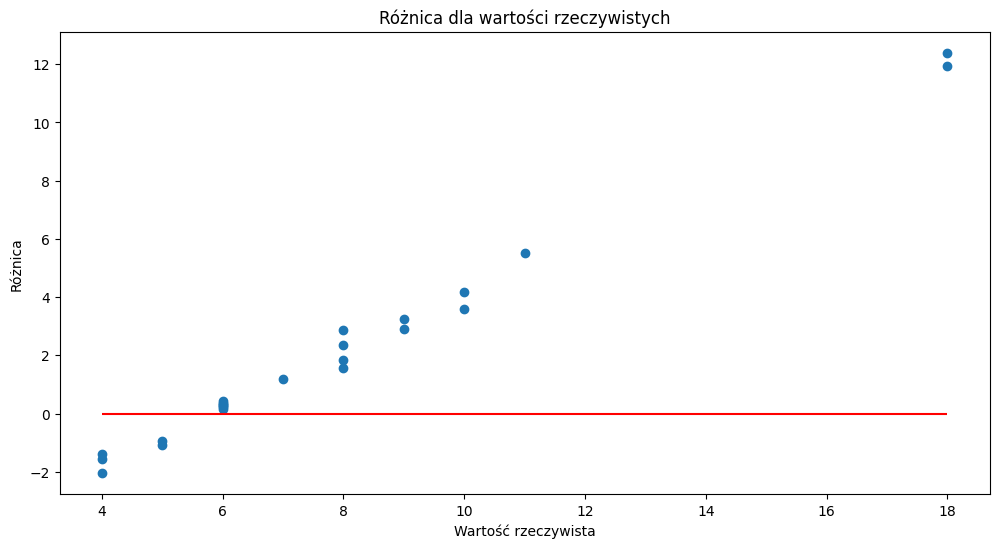

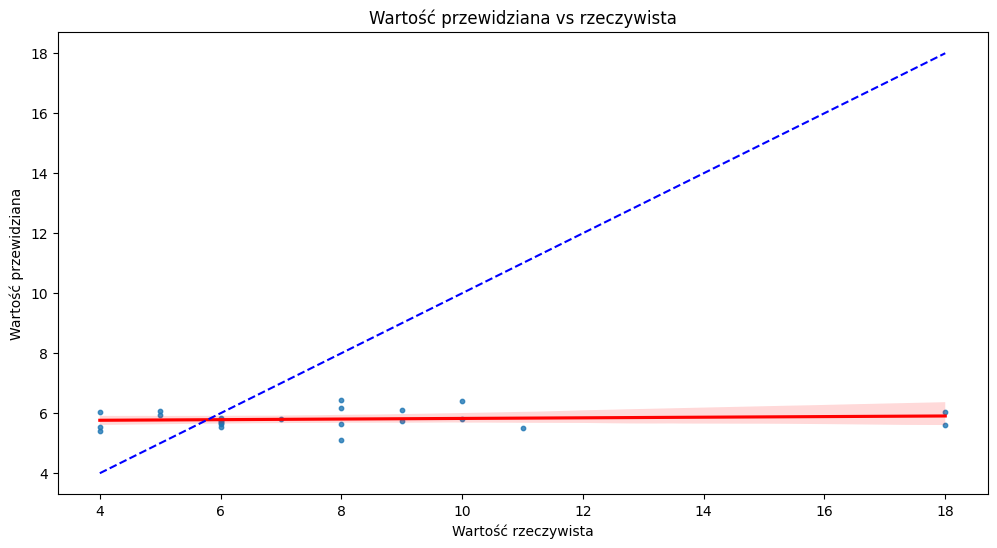

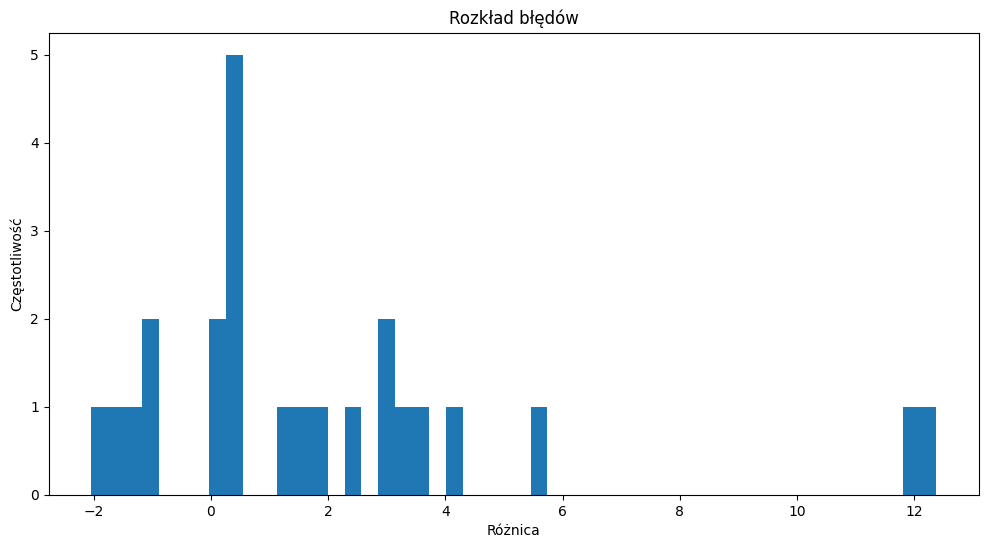

In [5]:
import re
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
root = '../own_data_test/'

filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.wav' in s]
filenames
# Load your model here
model = load_model('model.h5')
model.load_weights('model.weights.h5')

def calculated_rr_and_predicted(file_name, root):
    respiratory_cycle_number = int(re.search(r'\d+', file_name).group())
    # audio_length = librosa.get_duration(filename=f'{root}{file_name}.wav')
    # rr = respiratory_cycle_number / (audio_length / 60)
    rr = respiratory_cycle_number

    # Load audio with 22050 Hz sampling rate
    data_x, sampling_rate = librosa.load(f'{root}{file_name}.wav', res_type='kaiser_fast')
    
    # Extract features using MFCC (50 features)
    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=50).T, axis=0)

    # Reshape features to match the model's input shape (1, 50, 1)
    features = features.reshape(1, 50, 1)
    
    # Get the prediction
    predicted_value = model.predict(features, verbose=0)[0][0]

    return pd.DataFrame(data=[[file_name, rr, 
                            #    (predicted_value / (audio_length / 60))
                               predicted_value
                               ]], columns=['patient_id', 'rr', "rr_predicted"])

i_list = []
for s in filenames:
    i = calculated_rr_and_predicted(s, root)
    i_list.append(i)
recording_info = pd.concat(i_list, axis=0)

# Calculate metrics
mae = mean_absolute_error(recording_info['rr'], recording_info['rr_predicted'])
mse = mean_squared_error(recording_info['rr'], recording_info['rr_predicted'])
r2 = r2_score(recording_info['rr'], recording_info['rr_predicted'])

metrics_df = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'R² Score'],
    'Value': [mae, mse, r2]
})


import os
if not os.path.isdir("plots_test"):
    os.makedirs('plots_test')

# Display the metrics
print(metrics_df)

# Plotting
def plot_results(df):
    # Calculate residuals
    residuals = df['rr'] - df['rr_predicted']
    
    # Residuals Plot
    plt.figure(figsize=(12, 6))
    plt.scatter(df['rr'], residuals)
    plt.hlines(y=0, xmin=min(df['rr']), xmax=max(df['rr']), colors='r')
    plt.title('Różnica dla wartości rzeczywistych')
    plt.xlabel('Wartość rzeczywista')
    plt.ylabel('Różnica')
    plt.savefig("plots_test/roznia_dla_wartosci_rel")
    plt.show()

    # Predicted vs Actual Values with Linear Regression
    plt.figure(figsize=(12, 6))
    sns.regplot(x='rr', y='rr_predicted', data=df, scatter_kws={'s':10}, line_kws={"color": "red"})
    plt.plot([min(df['rr']), max(df['rr'])], [min(df['rr']), max(df['rr'])], color='blue', linestyle='dashed')  # Line of perfect prediction
    plt.title('Wartość przewidziana vs rzeczywista')
    plt.xlabel('Wartość rzeczywista')
    plt.ylabel('Wartość przewidziana')
    plt.savefig("plots_test/pred_vs_rel")
    plt.show()

    # Error Distribution (Histogram of residuals)
    plt.figure(figsize=(12, 6))
    plt.hist(residuals, bins=50)
    plt.title('Rozkład błędów')
    plt.xlabel('Różnica')
    plt.ylabel('Częstotliwość')
    plt.savefig("plots_test/rozklad_bledow")
    plt.show()

# Call the plotting function
plot_results(recording_info)